# P4    MODELISATION

## Librairies

In [175]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
#
from sklearn.svm import SVR
# Lineaire
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
 
# Ensemble
from sklearn.ensemble import RandomForestRegressor


import sklearn.metrics 
from sklearn import metrics
import matplotlib.pyplot  as plt
import numpy as np

## Importation du dataset

In [176]:
# LECTURE DONNEES
# path='/content/drive/MyDrive/df_reduit_cleaned.csv'
path='df15_16_clean.csv'
df=pd.read_csv(path)

## Preparation des données

In [177]:
df.head(2)

,Unnamed: 0,Longitude,Latitude,Address,GHGEmissionsIntensity(kgCO2e/ft2),CouncilDistrictCode,Neighborhood,NumberofBuildings,YearBuilt,ZipCode,PropertyGFATotal,Electricity(kBtu)_Prc,NaturalGas(kBtu)_Prc,SteamUse(kBtu)_Prc,ENERGYSTARScore,TotalGHGEmissions,SiteEnergyUse(kBtu)
0,1,-122.320787,47.547734,6100 CORSON AVE S,1.88,2,GREATER DUWAMISH,1.0,1992,98108.0,22452,0.435589,0.564411,0.0,78.0,44.71,1354219.0
1,3,-122.333131,47.626359,800 FAIRVIEW AVE N,1.64,3,LAKE UNION,1.0,1990,98109.0,282863,0.565004,0.434996,0.0,40.0,509.18,18829136.0


In [178]:
df=df.set_index('Unnamed: 0')

In [179]:
df.shape

(1975, 16)

### Suppression de variables

In [180]:
df.drop(['Longitude','Latitude','Address','Neighborhood','ZipCode'],axis=1,inplace=True)

In [181]:
#Reorganisation des colonnes
df.columns

Index(['GHGEmissionsIntensity(kgCO2e/ft2)', 'CouncilDistrictCode',
       'NumberofBuildings', 'YearBuilt', 'PropertyGFATotal',
       'Electricity(kBtu)_Prc', 'NaturalGas(kBtu)_Prc', 'SteamUse(kBtu)_Prc',
       'ENERGYSTARScore', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)'],
      dtype='object')

In [182]:
# Traitement variable 'NumberofBuildings'
df[['NumberofBuildings']].value_counts()


NumberofBuildings
1.0                  1938
0.0                    24
2.0                     4
4.0                     2
6.0                     2
7.0                     2
3.0                     1
8.0                     1
9.0                     1
dtype: int64

In [183]:
# Dummisation de la variable 'NumberofBuildings'
df=pd.get_dummies(df,columns = ['CouncilDistrictCode'],sparse=False)

In [184]:
df.columns

Index(['GHGEmissionsIntensity(kgCO2e/ft2)', 'NumberofBuildings', 'YearBuilt',
       'PropertyGFATotal', 'Electricity(kBtu)_Prc', 'NaturalGas(kBtu)_Prc',
       'SteamUse(kBtu)_Prc', 'ENERGYSTARScore', 'TotalGHGEmissions',
       'SiteEnergyUse(kBtu)', 'CouncilDistrictCode_1', 'CouncilDistrictCode_2',
       'CouncilDistrictCode_3', 'CouncilDistrictCode_4',
       'CouncilDistrictCode_5', 'CouncilDistrictCode_6',
       'CouncilDistrictCode_7'],
      dtype='object')

In [185]:
print("Nombre de variables restantes:",len(df.columns))

Nombre de variables restantes: 17


### Distridution des variables à prédire

array([[<AxesSubplot:title={'center':'SiteEnergyUse(kBtu)'}>,
        <AxesSubplot:title={'center':'TotalGHGEmissions'}>]], dtype=object)

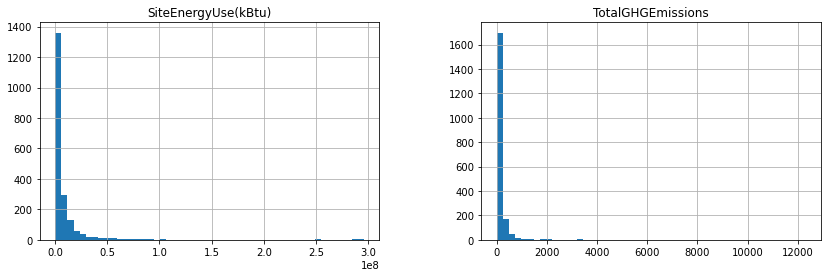

In [186]:
# Distridution de la variable a predire
df[['SiteEnergyUse(kBtu)','TotalGHGEmissions']].hist(figsize=(14,4),bins=50)

### Suppression des outliers  par observation du graphique ci-dessus

In [187]:
#Pour la variable'SiteEnergyUse(kBtu)'
index_a_supprimer=df[df['SiteEnergyUse(kBtu)']>=(0.5*10**8)].index
df.drop(index_a_supprimer,inplace=True)

In [188]:
#Pour la variable'SiteEnergyUse(kBtu)'
index_a_supprimer2=df[df['TotalGHGEmissions']>=(1000)].index
df.drop(index_a_supprimer2,inplace=True)

array([[<AxesSubplot:title={'center':'SiteEnergyUse(kBtu)'}>,
        <AxesSubplot:title={'center':'TotalGHGEmissions'}>]], dtype=object)

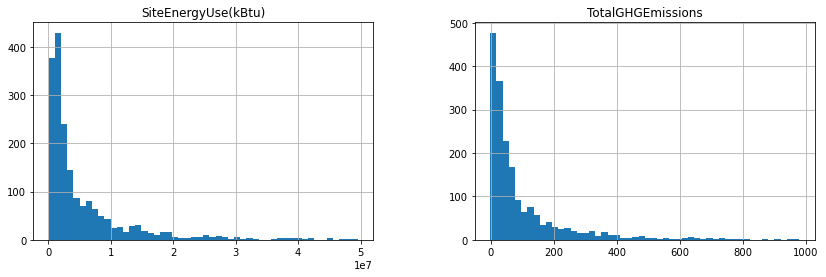

In [189]:
# Distridution des variables a predire  après suppression des outliers
df[['SiteEnergyUse(kBtu)','TotalGHGEmissions']].hist(figsize=(14,4),bins=50)

### Transformation logarithmique des variables à prédire

In [190]:
# Transformation logarithmique des variables à prédire
df['SiteEnergyUse(kBtu)_log'] = np.log(df['SiteEnergyUse(kBtu)']+1)
df['TotalGHGEmissions_log'] = np.log(df['TotalGHGEmissions']+1)

array([[<AxesSubplot:title={'center':'SiteEnergyUse(kBtu)_log'}>,
        <AxesSubplot:title={'center':'TotalGHGEmissions_log'}>]],
      dtype=object)

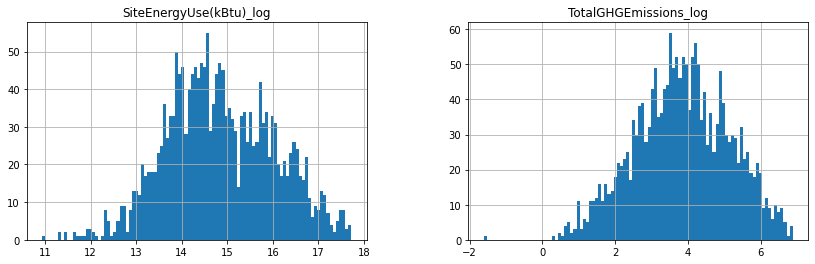

In [191]:
df[['SiteEnergyUse(kBtu)_log','TotalGHGEmissions_log']].hist(figsize=(14,4),bins=100)

# Prediction Consommation d' Energie:
       Sans les variables 'ENERGYSTARScore', 'TotalGHGEmissions**

In [192]:
df.columns

Index(['GHGEmissionsIntensity(kgCO2e/ft2)', 'NumberofBuildings', 'YearBuilt',
       'PropertyGFATotal', 'Electricity(kBtu)_Prc', 'NaturalGas(kBtu)_Prc',
       'SteamUse(kBtu)_Prc', 'ENERGYSTARScore', 'TotalGHGEmissions',
       'SiteEnergyUse(kBtu)', 'CouncilDistrictCode_1', 'CouncilDistrictCode_2',
       'CouncilDistrictCode_3', 'CouncilDistrictCode_4',
       'CouncilDistrictCode_5', 'CouncilDistrictCode_6',
       'CouncilDistrictCode_7', 'SiteEnergyUse(kBtu)_log',
       'TotalGHGEmissions_log'],
      dtype='object')

In [193]:
# Données à utilisées pour la prediction de consommation d'énergie
df_new= df.drop(['GHGEmissionsIntensity(kgCO2e/ft2)','ENERGYSTARScore','TotalGHGEmissions','SiteEnergyUse(kBtu)','TotalGHGEmissions_log','SiteEnergyUse(kBtu)_log'],axis=1) 
X=df_new.values
y = df['SiteEnergyUse(kBtu)_log'].values

In [194]:
# Fractionnement
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=42,shuffle=True)

In [195]:
# Dimension des fractionnements
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1317, 13) (565, 13) (1317,) (565,)


In [196]:
#Standardisation
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [197]:
r=pd.DataFrame(X_train_scaled)
r.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03,1.317000e+03
mean,-5.678618e-16,6.293582e-16,7.260285e-17,3.199668e-15,-1.402068e-15,2.538676e-16,1.934671e-16,-6.710232e-17,8.337210e-17,1.483669e-17,-1.718865e-16,1.011593e-18,-3.604642e-16
std,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00,1.000380e+00
min,-8.058578e+00,-1.995838e+00,-5.633927e-01,-2.784239e+00,-9.507955e-01,-2.173160e-01,-2.610106e-01,-5.700436e-01,-3.476364e-01,-3.407370e-01,-2.988813e-01,-2.692129e-01,-7.010751e-01
25%,8.658487e-02,-7.852293e-01,-4.783421e-01,-7.980261e-01,-9.507955e-01,-2.173160e-01,-2.610106e-01,-5.700436e-01,-3.476364e-01,-3.407370e-01,-2.988813e-01,-2.692129e-01,-7.010751e-01
50%,8.658487e-02,1.386567e-01,-3.576532e-01,1.964738e-01,-3.262308e-01,-2.173160e-01,-2.610106e-01,-5.700436e-01,-3.476364e-01,-3.407370e-01,-2.988813e-01,-2.692129e-01,-7.010751e-01
75%,8.658487e-02,7.758194e-01,1.133325e-02,1.016301e+00,7.902635e-01,-2.173160e-01,-2.610106e-01,-5.700436e-01,-3.476364e-01,-3.407370e-01,-2.988813e-01,-2.692129e-01,1.426381e+00
max,8.231747e+00,1.667847e+00,8.925485e+00,1.016301e+00,2.872980e+00,7.949916e+00,3.831262e+00,1.754252e+00,2.876569e+00,2.934815e+00,3.345810e+00,3.714533e+00,1.426381e+00


### Modelisation avec l'algorithme de regression 

In [198]:
# Instanciation du modele et détermination des paramètres
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

#Prediction
y_pred = reg.predict(X_test_scaled)

#### Etude avec log

Text(0, 0.5, 'Y_pred')

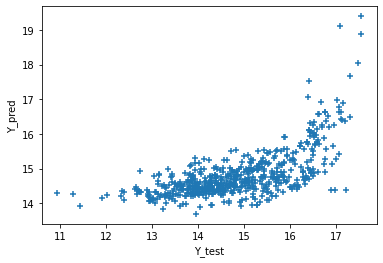

In [199]:

# Ploting(y_test, prediction) avec transformation logarithmique de la variable à expliquer.
plt.scatter(y_test,y_pred,marker="+")
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

In [200]:
# Evaluation de la Performance du modele par des métriques classiques

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test,y_pred))

MAE: 0.6986204001492061
MSE: 0.7833585430657743
RMSE: 0.8850754448439829
R2 Score: 0.42288365858967103


**Coefficients de la regression linéaire**

In [201]:
# Affichage des coefficients
Coefficient=pd.DataFrame(reg.coef_,df_new.columns)
Coefficient.columns=['Coefficients']
Coefficient 


,Coefficients
NumberofBuildings,-5.254255e-02
YearBuilt,2.056107e-01
PropertyGFATotal,6.528408e-01
Electricity(kBtu)_Prc,-3.353602e+11
NaturalGas(kBtu)_Prc,-3.333223e+11
SteamUse(kBtu)_Prc,-1.100035e+11
CouncilDistrictCode_1,3.334974e+11
CouncilDistrictCode_2,5.871725e+11
CouncilDistrictCode_3,4.232864e+11
CouncilDistrictCode_4,4.166511e+11


**OBSERVATION:**
Nous avons l'équation suivante:
    
**SiteEnergyUse(kBtu)_log= -5.254255e-02 x NumberofBuildings + 2.056107e-01  x YearBuilt +...+ 6.414997e+11 x CouncilDistrictCode_7**
   
**INTERPRETATION:** exemple la variation d'une unité de **YearBuilt** entraîne la variation de consommation d énergie de **2.056107e-01**; On peut utiliser le même raisonnement pour tous les coefficients. 

#### Etude sans log

Text(0, 0.5, 'Y_pred')

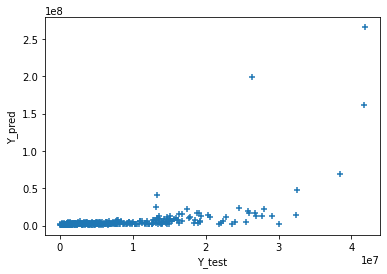

In [202]:
#Ploting(y_test, prediction) sans  logarithme
plt.scatter(np.exp(y_test),np.exp(y_pred),marker="+")
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

In [203]:
# Evaluation de la Performance du modele par des métriques classiques(sans log)
y_test_sans_log=np.exp(y_test)
y_pred_sans_log=np.exp(y_pred)
print('MAE:', metrics.mean_absolute_error(y_test_sans_log, y_pred_sans_log))
print('MSE:', metrics.mean_squared_error(y_test_sans_log, y_pred_sans_log))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_sans_log, y_pred_sans_log)))
print('R2 Score:', metrics.r2_score(y_test_sans_log,y_pred_sans_log))

MAE: 3701636.757633648
MSE: 191345874482389.6
RMSE: 13832782.600850401
R2 Score: -3.450526349999116


In [204]:
np.mean(y_test_sans_log)

5272367.961092178

In [205]:
np.std(y_test_sans_log)

6556980.063253646

#### Cross-validation

In [206]:
# Evaluation de la Performance du modele par cross-validation
scoring="neg_mean_squared_error"
model=LinearRegression()
kfold =KFold(n_splits=5, random_state=None)
cv_resultats = -cross_val_score(model,X_train_scaled,y_train, cv=kfold,scoring=scoring)

cv_resultats.mean()

0.7887341640458558

#### Score sur les données de test

In [207]:
cv_resultats = -cross_val_score(model,X_test_scaled,y_test, cv=kfold,scoring=scoring)

cv_resultats.mean()

0.8083143273020867

### Modelisation avec des algorithmes de regression lineaire

In [208]:
# Dictionnaire des Algorithmes

models={}
models={
    ('LR',LinearRegression()),
    ('RF', RandomForestRegressor()),
    ('KNN', KNeighborsRegressor()),
    ('RIDGE', Ridge()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('SVR',SVR()),
       }

# Métrique  utilisée
scoring='neg_mean_squared_error'

#### Etude avec log

In [209]:
# Evaluation de chaque modele avec transformation logarithmique de la cible.
resultats = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_resultats = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultats.append(cv_resultats)
    names.append(name)
    print("%s: %f, [%f]" % (name, -cv_resultats.mean(), cv_resultats.std()))

KNN: 0.539929, [0.106758]
RF: 0.320135, [0.074206]
RIDGE: 0.775220, [0.114844]
SVR: 0.547297, [0.089754]
LASSO: 0.829818, [0.114615]
LR: 0.775300, [0.114746]
EN: 0.828943, [0.114731]


#### Etude sans log

In [210]:
# Evaluation de chaque modele sans transformation logarithmique de la cible.
y_train_sans_log=np.exp(y_train)

resultats = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_resultats = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultats.append(cv_resultats)
    names.append(name)
    print("%s: %f, [%f]" % (name, -cv_resultats.mean(), cv_resultats.std()))

KNN: 0.539929, [0.106758]
RF: 0.318465, [0.070280]
RIDGE: 0.775220, [0.114844]
SVR: 0.547297, [0.089754]
LASSO: 0.829818, [0.114615]
LR: 0.775300, [0.114746]
EN: 0.828943, [0.114731]


### Tuning

In [211]:
# Tuning  RandomForestRegressor
param_grid = [
                {'n_estimators': [200, 300,500], 
                'max_features': [4, 8,12]}
             ]
scoring='neg_mean_squared_error'

#### Tuning Avec log

In [212]:
RFreg=RandomForestRegressor()
grid_search = GridSearchCV(RFreg, param_grid, cv=10,scoring=scoring,return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

-0.3093270483536705
RandomForestRegressor(max_features=8, n_estimators=500)


#### Tuning Sans log

In [213]:
y_train_sans_log=np.exp(y_train)
RFreg=RandomForestRegressor()
grid_search = GridSearchCV(RFreg, param_grid, cv=10,scoring=scoring,return_train_score=True)
grid_search.fit(X_train, y_train_sans_log)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

-10798669840950.254
RandomForestRegressor(max_features=8, n_estimators=300)


### Importance des variables

In [214]:

RFreg = RandomForestRegressor(max_features=8,n_estimators=300, random_state=1)
RFreg.fit(X, y)
# compute feature importances
df_feat_importance=pd.DataFrame({'feature':df_new.columns, 'importance':RFreg.feature_importances_})  #.sort('importance', ascending = False)
df_feat_importance.sort_values('importance', ascending = False)

,feature,importance
2,PropertyGFATotal,0.649721
1,YearBuilt,0.134898
3,Electricity(kBtu)_Prc,0.065158
4,NaturalGas(kBtu)_Prc,0.051656
12,CouncilDistrictCode_7,0.038018
7,CouncilDistrictCode_2,0.016986
9,CouncilDistrictCode_4,0.008821
6,CouncilDistrictCode_1,0.008173
11,CouncilDistrictCode_6,0.007367
8,CouncilDistrictCode_3,0.007298


**Les 5 premiers features contribuent le plus à l'élaboration de la regression**

#### Modele avec selection de variables

In [215]:
# Tuning  RandomForestRegressor
param_grid = [
                {'n_estimators': [200, 300,500], 
                'max_features': [4, 8,12]}
             ]
scoring='neg_mean_squared_error'

RFreg=RandomForestRegressor()
grid_search = GridSearchCV(RFreg, param_grid, cv=10,scoring=scoring,return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

-0.31280164157700846
RandomForestRegressor(max_features=8, n_estimators=500)


# Prediction Emission CO2 :


## Prediction Sans ENERGYSTARScore

### Preparation des données

In [216]:
# Suppression 
df_new= df.drop(['GHGEmissionsIntensity(kgCO2e/ft2)','ENERGYSTARScore','TotalGHGEmissions','SiteEnergyUse(kBtu)','TotalGHGEmissions_log','SiteEnergyUse(kBtu)_log'],axis=1)  
X=df_new.values
y = df['TotalGHGEmissions'].values

### Modelisation avec l'algorithme de regression 

In [217]:
# Instanciation du modele et détermination des paramètres
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

LinearRegression()

In [218]:
#Prediction
y_pred = reg.predict(X_test_scaled)

#### Etude avec log

Text(0, 0.5, 'Y_pred')

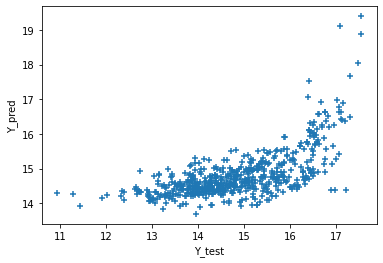

In [219]:
# Ploting(y_test, prediction) avec transformation logarithmique de la variable à expliquer.
plt.scatter(y_test,y_pred,marker="+")
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

In [220]:
# Evaluation de la Performance du modele par des métriques classiques

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test,y_pred))

MAE: 0.6986204001492061
MSE: 0.7833585430657743
RMSE: 0.8850754448439829
R2 Score: 0.42288365858967103


**Coefficients du modele lineaire**

In [221]:
# Affichage des coefficients
Coefficient=pd.DataFrame(reg.coef_,df_new.columns)
Coefficient.columns=['Coefficients']
Coefficient 

,Coefficients
NumberofBuildings,-5.254255e-02
YearBuilt,2.056107e-01
PropertyGFATotal,6.528408e-01
Electricity(kBtu)_Prc,-3.353602e+11
NaturalGas(kBtu)_Prc,-3.333223e+11
SteamUse(kBtu)_Prc,-1.100035e+11
CouncilDistrictCode_1,3.334974e+11
CouncilDistrictCode_2,5.871725e+11
CouncilDistrictCode_3,4.232864e+11
CouncilDistrictCode_4,4.166511e+11


#### Etude sans log

MAE: 5272353.160851499
MSE: 70791688341570.11
RMSE: 8413779.670372294
R2 Score: -0.6465485612237714


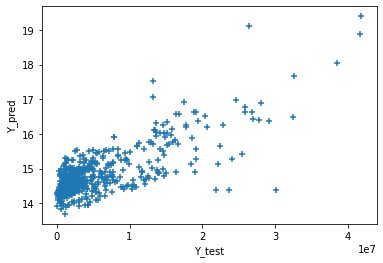

In [222]:
#Ploting(y_test, prediction) sans  logarithme
plt.scatter(np.exp(y_test),y_pred,marker="+")
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

# Evaluation de la Performance du modele par des métriques classiques(sans log)
y_test_sans_log=np.exp(y_test)

print('MAE:', metrics.mean_absolute_error(y_test_sans_log, y_pred))
print('MSE:', metrics.mean_squared_error(y_test_sans_log, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_sans_log, y_pred)))
print('R2 Score:', metrics.r2_score(y_test_sans_log,y_pred))

#### Cross-validation

In [223]:
# Evaluation de la Performance du modele par cross-validation
scoring="neg_mean_squared_error"
model=LinearRegression()
kfold =KFold(n_splits=5, random_state=None)
cv_resultats = cross_val_score(model,X_train_scaled,y_train, cv=kfold,scoring=scoring)

cv_resultats.mean()

-0.7887341640458558

### Modélisation des algorithmes de regression

In [224]:
# Dictionnaire des Algorithmes

models={}
models={
    ('LR',LinearRegression()),
    ('RF', RandomForestRegressor()),
    ('KNN', KNeighborsRegressor()),
    ('RIDGE', Ridge()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('SVR',SVR()),
       }

# Métrique  utilisée
scoring='neg_mean_squared_error'

#### Etude avec log

In [225]:
# Evaluation de chaque modele
resultats = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_resultats = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultats.append(cv_resultats)
    names.append(name)
    print("%s: %f, [%f]" % (name, -cv_resultats.mean(), cv_resultats.std()))

RIDGE: 0.775220, [0.114844]
SVR: 0.547297, [0.089754]
KNN: 0.539929, [0.106758]
LASSO: 0.829818, [0.114615]
EN: 0.828943, [0.114731]
RF: 0.319184, [0.068322]
LR: 0.775300, [0.114746]


#### Etude sans log

In [226]:
# Evaluation de chaque modele sans transformation logarithmique de la cible.
y_train_sans_log=np.exp(y_train)

resultats = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_resultats = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultats.append(cv_resultats)
    names.append(name)
    print("%s: %f, [%f]" % (name, -cv_resultats.mean(), cv_resultats.std()))

RIDGE: 0.775220, [0.114844]
SVR: 0.547297, [0.089754]
KNN: 0.539929, [0.106758]
LASSO: 0.829818, [0.114615]
EN: 0.828943, [0.114731]
RF: 0.317063, [0.066410]
LR: 0.775300, [0.114746]


#### Tuning

In [227]:
# Tuning  RandomForestRegressor
param_grid = [
                {'n_estimators': [ 200, 300,500], 
                'max_features': [4, 8,12]}
             ]
scoring='neg_mean_squared_error'

#### Tuning Avec log

In [228]:
# Tuning  RandomForestRegressor
param_grid = [
                {'n_estimators': [ 200, 300,500], 
                'max_features': [4, 8,12]}
             ]
scoring='neg_mean_squared_error'

RFreg=RandomForestRegressor()
grid_search = GridSearchCV(RFreg, param_grid, cv=10,scoring=scoring,return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

-0.31198562628271287
RandomForestRegressor(max_features=8, n_estimators=300)


#### Tuning Sans log

In [229]:
y_train_sans_log=np.exp(y_train)
RFreg=RandomForestRegressor()
grid_search = GridSearchCV(RFreg, param_grid, cv=10,scoring=scoring,return_train_score=True)
grid_search.fit(X_train, y_train_sans_log)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

-10859908779161.967
RandomForestRegressor(max_features=8, n_estimators=500)


## Prediction Avec ENERGYSTARScore

### Preparation des données

In [230]:
# Suppression 
X = df.drop(['GHGEmissionsIntensity(kgCO2e/ft2)','TotalGHGEmissions','SiteEnergyUse(kBtu)','TotalGHGEmissions_log','SiteEnergyUse(kBtu)_log'],axis=1) 
X=df_new.values
y = df['TotalGHGEmissions'].values

### Modelisation avec l'algorithme de regression seul

In [231]:
# Instanciation du modele et détermination des paramètres
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

#Prediction
y_pred = reg.predict(X_test_scaled)

#### Etude avec log

Text(0, 0.5, 'Y_pred')

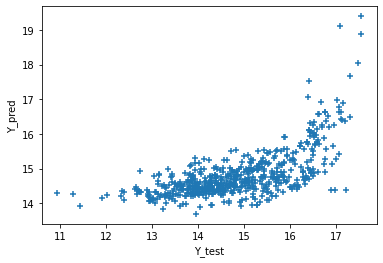

In [232]:
# Ploting(y_test, prediction) avec transformation logarithmique de la variable à expliquer.
plt.scatter(y_test,y_pred,marker="+")
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

In [233]:
# Evaluation de la Performance du modele par des métriques classiques

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test,y_pred))

MAE: 0.6986204001492061
MSE: 0.7833585430657743
RMSE: 0.8850754448439829
R2 Score: 0.42288365858967103


**Coefficients du modele lineaire**

In [234]:
# Affichage des coefficients
Coefficient=pd.DataFrame(reg.coef_,df_new.columns)
Coefficient.columns=['Coefficients']
Coefficient 

,Coefficients
NumberofBuildings,-5.254255e-02
YearBuilt,2.056107e-01
PropertyGFATotal,6.528408e-01
Electricity(kBtu)_Prc,-3.353602e+11
NaturalGas(kBtu)_Prc,-3.333223e+11
SteamUse(kBtu)_Prc,-1.100035e+11
CouncilDistrictCode_1,3.334974e+11
CouncilDistrictCode_2,5.871725e+11
CouncilDistrictCode_3,4.232864e+11
CouncilDistrictCode_4,4.166511e+11


#### Etude sans log

Text(0, 0.5, 'Y_pred')

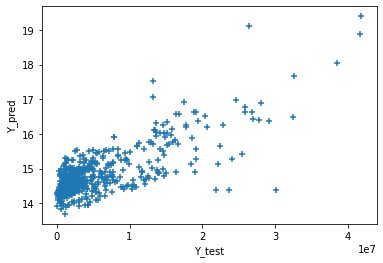

In [235]:
#Ploting(y_test, prediction) sans  logarithme
plt.scatter(np.exp(y_test),y_pred,marker="+")
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

In [236]:
# Evaluation de la Performance du modele par des métriques classiques(sans log)
y_test_sans_log=np.exp(y_test)

print('MAE:', metrics.mean_absolute_error(y_test_sans_log, y_pred))
print('MSE:', metrics.mean_squared_error(y_test_sans_log, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_sans_log, y_pred)))
print('R2 Score:', metrics.r2_score(y_test_sans_log,y_pred))

MAE: 5272353.160851499
MSE: 70791688341570.11
RMSE: 8413779.670372294
R2 Score: -0.6465485612237714


#### Cross-validation

In [237]:
# Evaluation de la Performance du modele par cross-validation
scoring="neg_mean_squared_error"
model=LinearRegression()
kfold =KFold(n_splits=5, random_state=None)
cv_resultats = cross_val_score(model,X_train_scaled,y_train, cv=kfold,scoring=scoring)

cv_resultats

array([-0.72094619, -0.75973175, -0.90793765, -0.6972626 , -0.85779263])

### Modélisation avec des algorithmes de regression

In [238]:
# Dictionnaire des Algorithmes

models={}
models={
    ('LR',LinearRegression()),
    ('RF', RandomForestRegressor()),
    ('KNN', KNeighborsRegressor()),
    ('RIDGE', Ridge()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('SVR',SVR()),
       }

# Métrique  utilisée
scoring='neg_mean_squared_error' 

#### Etude avec log

In [239]:
         
# Evaluation de chaque modele
resultats = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_resultats = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultats.append(cv_resultats)
    names.append(name)
    print("%s: %f, [%f]" % (name, -cv_resultats.mean(), cv_resultats.std()))

RIDGE: 0.775220, [0.114844]
KNN: 0.539929, [0.106758]
LASSO: 0.829818, [0.114615]
LR: 0.775300, [0.114746]
SVR: 0.547297, [0.089754]
RF: 0.319500, [0.069134]
EN: 0.828943, [0.114731]


#### Etude sans  log

In [240]:
# Evaluation de chaque modele sans transformation logarithmique de la cible.
y_train_sans_log=np.exp(y_train)

resultats = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_resultats = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultats.append(cv_resultats)
    names.append(name)
    print("%s: %f, [%f]" % (name, -cv_resultats.mean(), cv_resultats.std()))

RIDGE: 0.775220, [0.114844]
KNN: 0.539929, [0.106758]
LASSO: 0.829818, [0.114615]
LR: 0.775300, [0.114746]
SVR: 0.547297, [0.089754]
RF: 0.318276, [0.071990]
EN: 0.828943, [0.114731]


#### Tuning

In [241]:
# Tuning  RandomForestRegressor
param_grid = [
                {'n_estimators': [200,300,500], 
                'max_features': [4, 8,12]}
             ]
scoring='neg_mean_squared_error'

RFreg=RandomForestRegressor()
grid_search = GridSearchCV(RFreg, param_grid, cv=10,scoring=scoring,return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

-0.3110747225512618
RandomForestRegressor(max_features=8, n_estimators=200)


In [242]:
#  FIN  #